In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist
from src.dataset import *
from src.concept_vectors import *
from src.util import *
from src.plots import *
from src.hierarchy import *
from src.metrics import *
from src.models import * 
from src.create_vectors import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity
from copy import copy
from collections import defaultdict, Counter
import pickle
from sklearn.neural_network import MLPClassifier
import time
from sklearn.ensemble import RandomForestClassifier

/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16"

## Dataset and Hierarchy Setup

In [4]:
dataset = CUB_Dataset()

In [5]:
attributes = dataset.get_attributes()

In [6]:
shapley_hierarchy = create_hierarchy(create_ward_hierarchy, load_shapley_vectors_simple,dataset,'',attributes,43)

In [7]:
label_hierarchy = create_hierarchy(create_ward_hierarchy, load_label_vectors_simple,dataset,'',attributes,43)

In [8]:
concept_group_map = defaultdict(list)
for i,concept_name in enumerate(attributes):
    group = concept_name[:concept_name.find("::")]
    concept_group_map[group].append(i)

In [9]:
all_groups = list(concept_group_map.keys())

In [10]:
train = pickle.load(open("dataset/{}/preprocessed/train.pkl".format(dataset.root_folder_name),"rb"))
val = pickle.load(open("dataset/{}/preprocessed/val.pkl".format(dataset.root_folder_name),"rb"))
test = pickle.load(open("dataset/{}/preprocessed/test.pkl".format(dataset.root_folder_name),"rb"))

In [11]:
len(train) + len(val) + len(test)

11788

In [12]:
train_paths = set([i['img_path'] for i in train])
val_paths = set([i['img_path'] for i in val])
test_paths = set([i['img_path'] for i in test])

In [13]:
val_paths.intersection(test_paths)

set()

## Similar Examples

In [14]:
def find_similar_examples(all_concepts,current_concept,dist_metric):    
    distances = cdist(np.atleast_2d(current_concept), all_concepts, metric=dist_metric)
    indices = np.argsort(distances.squeeze())[:5]
    
    return indices

In [15]:
def plot_closest_images(all_concepts,current_concept,concept_idx,dataset,dist_metric):
    class_names = dataset.class_names
    
    close_examples = find_similar_examples(all_concepts,current_concept,dist_metric)
    current_img_path = dataset.get_data(train=False)[concept_idx]['img_path']
    current_y_val = dataset.get_data(train=False)[concept_idx]['class_label']
        
    train_data = dataset.get_data()

    fig, axes = plt.subplots(1, 6, figsize=(15, 3))
    
    for i, ax in enumerate(axes):
        if i == 0:
            ax.set_title("Ref: {}".format(class_names[current_y_val].split(".")[1].replace("_"," ")),fontsize=20)
            image = Image.open('dataset/'+current_img_path).resize((64,64))
            ax.imshow(image)
            ax.axis('off')
        else:
            j = close_examples[i-1]
            ax.set_title("{}".format(class_names[train_data[j]['class_label']].split(".")[1].replace("_"," ")),fontsize=20)
            image = Image.open('dataset/'+train_data[j]['img_path']).resize((64,64))
            ax.imshow(image)
            ax.axis('off')

    plt.tight_layout()    

In [16]:
def get_new_vals(intervention_idxs,related_concepts,c,true_c=None):
    new_c = copy(c)
    
    if true_c is None:
        true_c = copy(c)
    else:
        for concept_idx in intervention_idxs:
            new_c[concept_idx] = true_c[concept_idx]

    for concept_idx in range(len(new_c)):
        if concept_idx in intervention_idxs:
            continue
        
        full_prob = 0
        num_divide = 0
        
        for reference_concept in related_concepts[concept_idx]:
            if reference_concept in intervention_idxs:
                num_divide += 1
                function, confidence = related_concepts[concept_idx][reference_concept]
                true_concept_value = true_c[reference_concept]
                
                full_prob += confidence*function(true_c[reference_concept]) + (1-confidence)*c[concept_idx]
                
        if num_divide > 0:
            full_prob /= num_divide
            new_c[concept_idx] = full_prob
            
    return new_c

In [17]:
def find_closest_vectors(matrix,num_indices=10):
    num_vectors = matrix.shape[0]
    sim_matrix = cosine_similarity(matrix)

    # Set diagonal to -inf to exclude self-similarity
    np.fill_diagonal(sim_matrix, -np.inf)

    closest_indices = []
    for i in range(num_vectors):
        cosine_similarities = sim_matrix[i]
        distances = [(j, abs(sim),sim) for j, sim in enumerate(cosine_similarities)]
        # Sort by distance in descending order
        distances.sort(key=lambda x: x[1], reverse=True)
        # Get the indices of the 3 closest vectors (excluding itself)
        closest_indices.append([(j, sim) for j, d, sim in distances if j != i][:num_indices])

    return closest_indices

In [18]:
def get_related_scores(embedding_matrix,power=0,num_indices=10):
    closest_vectors = find_closest_vectors(embedding_matrix,num_indices=num_indices)
    related_concept2vec = {}
    identity_function = lambda s: s
    opposite_function = lambda s: 1-s
    
    n_concepts = num_columns

    for i in range(n_concepts):
        related_concept2vec[i] = {}

        for index,similarity in closest_vectors[i]:
            confidence = abs(similarity)**power
            if similarity > 0:
                related_concept2vec[i][index] = (identity_function,confidence)
            else:
                related_concept2vec[i][index] = (opposite_function,confidence)
                
    return related_concept2vec

In [19]:
def evaluate_knn(train_x,train_y,valid_x,valid_y):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(train_x, train_y)
    return sum(knn.predict(valid_x) == valid_y)/len(valid_y)

In [20]:
train_x = np.array([i['attribute_label'] for i in dataset.get_data()])
train_logits = np.load("results/logits/{}/train_c.npy".format(dataset.experiment_name)) 
train_y = np.array([i['class_label'] for i in pickle.load(open("dataset/{}/preprocessed/train.pkl".format(dataset.root_folder_name),"rb"))])

valid_x = np.array([i['attribute_label'] for i in pickle.load(open("dataset/{}/preprocessed/val.pkl".format(dataset.root_folder_name),"rb"))])
valid_logits = np.load("results/logits/{}/valid_c.npy".format(dataset.experiment_name))
valid_y = np.array([i['class_label'] for i in pickle.load(open("dataset/{}/preprocessed/val.pkl".format(dataset.root_folder_name),"rb"))])

test_x = np.array([i['attribute_label'] for i in pickle.load(open("dataset/{}/preprocessed/test.pkl".format(dataset.root_folder_name),"rb"))])
test_logits = np.load("results/logits/{}/test_c.npy".format(dataset.experiment_name))
test_y = np.array([i['class_label'] for i in pickle.load(open("dataset/{}/preprocessed/test.pkl".format(dataset.root_folder_name),"rb"))])

In [21]:
def dist(x, y, indices):
    diff = np.abs(x-y)*indices
    return np.mean(diff)

In [22]:
example_idx = 0

In [23]:
def traverse_hierarchy(hierarchy):
    all_groups = []
    if hierarchy.left_split.leaf or hierarchy.right_split.leaf:
        all_groups.append(hierarchy.value)
    else:
        all_groups += traverse_hierarchy(hierarchy.left_split)
        all_groups += traverse_hierarchy(hierarchy.right_split)
    
    return all_groups 

def groups_to_indices(groups):
    indices = [[dataset.get_attributes().index(j) for j in i] for i in groups]
    num_attributes = sum([len(i) for i in indices])
    
    ret = [1 for i in range(num_attributes)]
    
    for i in indices:
        for j in i:
            ret[j] = 1/len(i)
            
    return np.array(ret)

In [24]:
groups_shapley = traverse_hierarchy(shapley_hierarchy.root_split)
indices_shapley = groups_to_indices(groups_shapley)

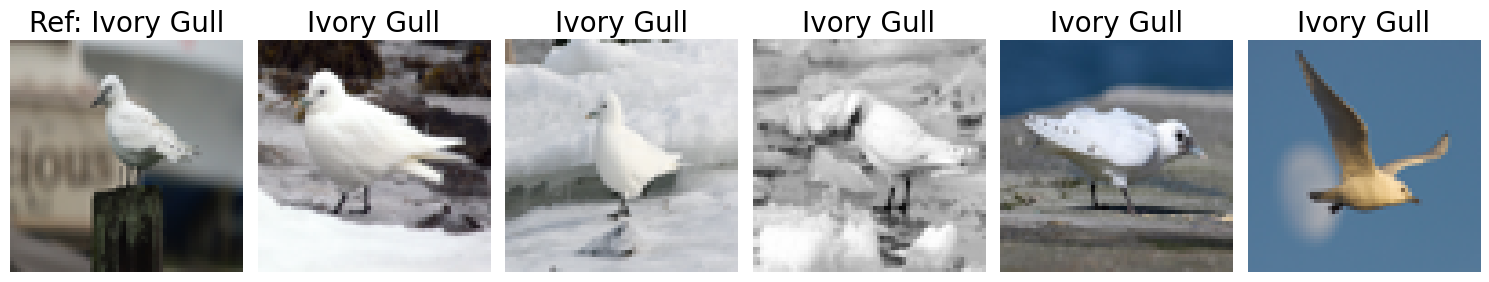

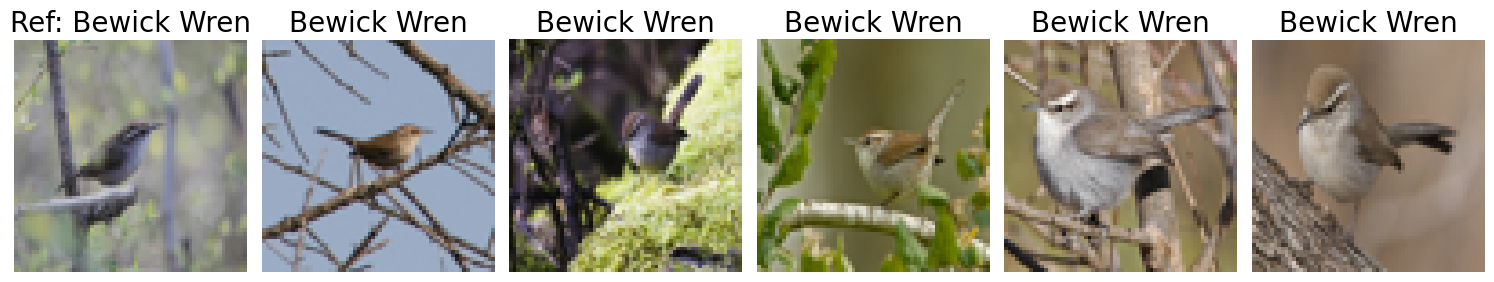

In [25]:
plot_closest_images(train_logits,valid_logits[example_idx],example_idx,dataset,lambda x,y: dist(x,y,indices_shapley))
plt.savefig("./scripts/Figures/close_birds_1.pdf",bbox_inches="tight")
plot_closest_images(train_logits,valid_logits[example_idx+4],example_idx+4,dataset,lambda x,y: dist(x,y,indices_shapley))
plt.savefig("./scripts/Figures/close_birds_2.pdf",bbox_inches="tight")

In [76]:
import time
start = time.time()
closest_images = []
for i in range(len(test_logits)):
    closest_images.append(list(find_similar_examples(train_logits,test_logits[i],lambda x,y: dist(x,y,indices_shapley))))
closest_images = np.array(closest_images)
print("Took {} time".format(time.time()-start))

Took 733.3564660549164 time


In [75]:
import time
start = time.time()
real_images = []
for i in range(len(test_logits)):
    if i%100 == 0:
        print(i)
    real_images.append(list(find_similar_examples(train_logits,test_logits[i],lambda x,y: np.sum(np.abs(x-y)))))
real_images = np.array(real_images)
print("Took {} time".format(time.time()-start))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
Took 400.9418604373932 time


In [77]:
np.sum(real_images == closest_images)/(real_images.size)

0.25712806351398

In [26]:
train_data = dataset.get_data()

In [79]:
closest_images_y = np.zeros(closest_images.shape)
for i in range(len(closest_images_y)):
    for j in range(len(closest_images_y[0])):
        closest_images_y[i][j] = train_data[closest_images[i][j]]['class_label']

In [80]:
real_images_y = np.zeros(real_images.shape)
for i in range(len(real_images_y)):
    for j in range(len(real_images_y[0])):
        real_images_y[i][j] = train_data[real_images[i][j]]['class_label']

In [81]:
np.sum(real_images_y == closest_images_y)/(real_images_y.size)

0.7561960648947187

In [62]:
find_similar_examples(train_logits,test_logits[0],lambda x,y: dist(x,y,indices_shapley))

array([   5,  219,  640, 3124, 1388])

In [27]:
num_columns = train_x.shape[1]

In [29]:
acc_by_col = [sum(np.round(train_logits[:,i]) == train_x[:,i])/len(train_logits[:,i]) for i in range(num_columns)]
best_indices = list(np.argsort(acc_by_col)[::-1])

In [23]:
train_concept_acc = np.sum(np.round(train_logits) == train_x)/(train_x.shape[0]*train_x.shape[1])
train_concept_acc

0.6999333333333333

In [24]:
valid_concept_acc = np.sum(np.round(valid_logits) == valid_x)/(valid_x.shape[0]*valid_x.shape[1])
valid_concept_acc

0.7022222222222222

In [25]:
test_concept_acc = np.sum(np.round(test_logits) == test_x)/(test_x.shape[0]*test_x.shape[1])
test_concept_acc

0.7004444444444444

## Training a KNN from this

In [31]:
evaluate_knn(train_logits,train_y,valid_logits,valid_y)

0.8772954924874792

In [34]:
evaluate_knn(np.round(train_logits),train_y,np.round(valid_logits),valid_y)

0.8681135225375626

In [46]:
for k in range(0,110,5):
    fixed_train = np.array([get_new_vals(best_indices[:k],labels_related,
                                         train_logits[i],train_x[i]) for i in range(len(train_logits))])
    fixed_val = np.array([get_new_vals(best_indices[:k],labels_related,
                                       valid_logits[i],valid_x[i]) for i in range(len(valid_logits))])
    accuracy = evaluate_knn(fixed_train,train_y,fixed_val,valid_y)
    print("For {}, accuracy: {}".format(k,accuracy))

For 0, accuracy: 0.8772954924874792
For 5, accuracy: 0.7570951585976627
For 10, accuracy: 0.7245409015025042
For 15, accuracy: 0.6828046744574291
For 20, accuracy: 0.7153589315525877
For 25, accuracy: 0.67779632721202
For 30, accuracy: 0.6368948247078464
For 35, accuracy: 0.6018363939899833
For 40, accuracy: 0.7028380634390651
For 45, accuracy: 0.7579298831385642
For 50, accuracy: 0.7654424040066778
For 55, accuracy: 0.82220367278798
For 60, accuracy: 0.8606010016694491
For 65, accuracy: 0.8797996661101837
For 70, accuracy: 0.9173622704507512
For 75, accuracy: 0.9282136894824707
For 80, accuracy: 0.9365609348914858
For 85, accuracy: 0.9449081803005008
For 90, accuracy: 0.9699499165275459
For 95, accuracy: 0.9858096828046744
For 100, accuracy: 0.993322203672788
For 105, accuracy: 1.0


In [47]:
for k in range(0,110,5):
    fixed_train = np.array([get_new_vals(best_indices[:k],labels_related,
                                         train_logits[i],None) for i in range(len(train_logits))])
    fixed_val = np.array([get_new_vals(best_indices[:k],labels_related,
                                       valid_logits[i],None) for i in range(len(valid_logits))])
    accuracy = evaluate_knn(fixed_train,train_y,fixed_val,valid_y)
    print("For {}, accuracy: {}".format(k,accuracy))

For 0, accuracy: 0.8772954924874792
For 5, accuracy: 0.7629382303839732
For 10, accuracy: 0.7195325542570952
For 15, accuracy: 0.676126878130217
For 20, accuracy: 0.6986644407345576
For 25, accuracy: 0.662771285475793
For 30, accuracy: 0.6026711185308848
For 35, accuracy: 0.5567612687813022
For 40, accuracy: 0.5901502504173622
For 45, accuracy: 0.6502504173622704
For 50, accuracy: 0.659432387312187
For 55, accuracy: 0.6919866444073456
For 60, accuracy: 0.7462437395659433
For 65, accuracy: 0.7604340567612687
For 70, accuracy: 0.7813021702838063
For 75, accuracy: 0.7921535893155259
For 80, accuracy: 0.7996661101836394
For 85, accuracy: 0.8096828046744574
For 90, accuracy: 0.8347245409015025
For 95, accuracy: 0.8505843071786311
For 100, accuracy: 0.8647746243739566
For 105, accuracy: 0.8681135225375626


In [72]:
for k in range(0,len(concept_group_map),4):
    random_groups = random.sample(all_groups,k)
    indices = []
    for group in random_groups:
        indices += concept_group_map[group]
                
    fixed_train = np.array([get_new_vals(indices,labels_related,
                                         train_logits[i],train_x[i]) for i in range(len(train_logits))])
    fixed_val = np.array([get_new_vals(indices,labels_related,
                                       valid_logits[i],valid_x[i]) for i in range(len(valid_logits))])
    accuracy = evaluate_knn(fixed_train,train_y,fixed_val,valid_y)
    print("For {}, accuracy: {}".format(k,accuracy))

For 0, accuracy: 0.8772954924874792
For 4, accuracy: 0.8806343906510852
For 8, accuracy: 0.8906510851419032
For 12, accuracy: 0.9432387312186978
For 16, accuracy: 0.994991652754591
For 20, accuracy: 0.988313856427379
For 24, accuracy: 1.0


In [73]:
for k in range(0,len(concept_group_map),4):
    random_groups = random.sample(all_groups,k)
    indices = []
    for group in random_groups:
        indices += concept_group_map[group]
        
    fixed_train = np.array([get_new_vals(indices,labels_related,
                                         train_logits[i],None) for i in range(len(train_logits))])
    fixed_val = np.array([get_new_vals(indices,labels_related,
                                       valid_logits[i],None) for i in range(len(valid_logits))])
    accuracy = evaluate_knn(fixed_train,train_y,fixed_val,valid_y)
    print("For {}, accuracy: {}".format(k,accuracy))

For 0, accuracy: 0.8772954924874792
For 4, accuracy: 0.7086811352253757
For 8, accuracy: 0.6969949916527546
For 12, accuracy: 0.8196994991652755
For 16, accuracy: 0.830550918196995
For 20, accuracy: 0.8555926544240401
For 24, accuracy: 0.8697829716193656


In [74]:
for k in range(0,len(concept_group_map),4):
    random_groups = random.sample(all_groups,k)
    indices = []
    for group in random_groups:
        indices += concept_group_map[group]
        
    fixed_train = np.array([get_new_vals(indices,shapley_related,
                                         train_logits[i],None) for i in range(len(train_logits))])
    fixed_val = np.array([get_new_vals(indices,shapley_related,
                                       valid_logits[i],None) for i in range(len(valid_logits))])
    accuracy = evaluate_knn(fixed_train,train_y,fixed_val,valid_y)
    print("For {}, accuracy: {}".format(k,accuracy))

For 0, accuracy: 0.8772954924874792
For 4, accuracy: 0.657762938230384
For 8, accuracy: 0.7646076794657763
For 12, accuracy: 0.8021702838063439
For 16, accuracy: 0.8263772954924875
For 20, accuracy: 0.8505843071786311
For 24, accuracy: 0.8706176961602671


In [75]:
for k in range(0,len(concept_group_map),4):
    random_groups = random.sample(all_groups,k)
    indices = []
    for group in random_groups:
        indices += concept_group_map[group]
        
    fixed_train = np.array([get_new_vals(indices,labels_related_1,
                                         train_logits[i],None) for i in range(len(train_logits))])
    fixed_val = np.array([get_new_vals(indices,labels_related_1,
                                       valid_logits[i],None) for i in range(len(valid_logits))])
    accuracy = evaluate_knn(fixed_train,train_y,fixed_val,valid_y)
    print("For {}, accuracy: {}".format(k,accuracy))

For 0, accuracy: 0.8772954924874792
For 4, accuracy: 0.7871452420701168
For 8, accuracy: 0.840567612687813
For 12, accuracy: 0.842237061769616
For 16, accuracy: 0.8689482470784641
For 20, accuracy: 0.8580968280467446
For 24, accuracy: 0.8772954924874792


In [76]:
for k in range(0,len(concept_group_map),4):
    random_groups = random.sample(all_groups,k)
    indices = []
    for group in random_groups:
        indices += concept_group_map[group]
        
    fixed_train = np.array([get_new_vals(indices,shapley_related_1,
                                         train_logits[i],None) for i in range(len(train_logits))])
    fixed_val = np.array([get_new_vals(indices,shapley_related_1,
                                       valid_logits[i],None) for i in range(len(valid_logits))])
    accuracy = evaluate_knn(fixed_train,train_y,fixed_val,valid_y)
    print("For {}, accuracy: {}".format(k,accuracy))

For 0, accuracy: 0.8772954924874792
For 4, accuracy: 0.8472454090150251
For 8, accuracy: 0.8589315525876461
For 12, accuracy: 0.8656093489148581
For 16, accuracy: 0.8572621035058431
For 20, accuracy: 0.8614357262103506
For 24, accuracy: 0.8739565943238731


In [77]:
for k in range(0,len(concept_group_map),4):
    random_groups = random.sample(all_groups,k)
    indices = []
    for group in random_groups:
        indices += concept_group_map[group]
        
    fixed_train = np.array([get_new_vals(indices,shapley_related,
                                         train_logits[i],None) for i in range(len(train_logits))])
    fixed_val = np.array([get_new_vals(indices,shapley_related,
                                       valid_logits[i],None) for i in range(len(valid_logits))])
    accuracy = evaluate_knn(np.round(fixed_train),train_y,np.round(fixed_val),valid_y)
    print("For {}, accuracy: {}".format(k,accuracy))

For 0, accuracy: 0.8681135225375626
For 4, accuracy: 0.6878130217028381
For 8, accuracy: 0.7295492487479132
For 12, accuracy: 0.7921535893155259
For 16, accuracy: 0.8380634390651085
For 20, accuracy: 0.8489148580968281
For 24, accuracy: 0.8606010016694491


## Debugging: Seeing how our intervention impacts individual data points

In [27]:
def get_different_attributes(x,y):
    return [a for i, a in enumerate(attributes) if x[i] != y[i]]

In [28]:
def run_diagnostics(fixed_train,fixed_val):
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(fixed_train, train_y)
    predictions = knn.predict(fixed_val)
    incorrect = (predictions != valid_y).nonzero()[0]
    incorrect_0 = incorrect[0]
    
    print("First incorrect point {}".format(incorrect_0))
    
    correct_y = valid_y[incorrect_0]
    predicted_neighbors = knn.kneighbors([fixed_val[incorrect_0]])[1]
    predicted_y = train_y[predicted_neighbors]
    
    print("Predicted neighbors {}".format(predicted_neighbors))
    print("Correct y {}, predicted_y {}".format(correct_y, predicted_y))
    
    predicted_logits = np.round(fixed_val[incorrect_0])
    real_logits = valid_x[incorrect_0]
    initial_train_logits = np.round(train_logits[predicted_neighbors[0][0]])
    closest_train_logits = np.round(fixed_train[predicted_neighbors[0][0]])
    real_train_logits = train_x[predicted_neighbors[0][0]]
    
    diff_train = get_different_attributes(initial_train_logits,real_train_logits)
    print("Differing attributes train {}".format(diff_train))
    
    diff_val = get_different_attributes(np.round(valid_logits[incorrect_0]),real_logits)
    print("Differing attributes val {}".format(diff_val))
    
    attribute_name = diff_train[0]
    idx = attributes.index(attribute_name)
    correct_prediction = real_train_logits[idx]

    print("Correct prediction for attribute {}: {}".format(attribute_name,correct_prediction))
    for i in shapley_related[idx]:
        print(attributes[i],real_train_logits[i])
    
    return incorrect_0


In [35]:
random_groups = random.sample(all_groups,12)
indices = []
for group in random_groups:
    indices += concept_group_map[group]

fixed_train = np.array([get_new_vals(indices,shapley_related,
                                 train_logits[i],None) for i in range(len(train_logits))])
fixed_val = np.array([get_new_vals(indices,shapley_related,
                               valid_logits[i],None) for i in range(len(valid_logits))])

In [37]:
incorrect_0 = run_diagnostics(fixed_train,fixed_val)

First incorrect point 2
Predicted neighbors [[3671  175 2820 1130 1206]]
Correct y 8, predicted_y [[ 29  28  29 106 106]]
Differing attributes train ['has_bill_length::about_the_same_as_head', 'has_wing_shape::rounded-wings', 'has_size::small_(5_-_9_in)']
Differing attributes val ['has_head_pattern::plain']
Correct prediction for attribute has_bill_length::about_the_same_as_head: 1
has_bill_length::shorter_than_head 0
has_shape::perching-like 0
has_size::medium_(9_-_16_in) 0
has_nape_color::white 0
has_bill_shape::dagger 0
has_bill_shape::cone 0
has_size::small_(5_-_9_in) 0
has_tail_shape::notched_tail 0
has_primary_color::white 0
has_upperparts_color::white 0


## New method for intervention

In [71]:
errors_by_group = []
for i in range(len(valid_logits)):
    real_logits = valid_x[i]
    predicted_logits = np.round(valid_logits[i])
    difference = get_different_attributes(real_logits,predicted_logits)
    difference = [i.split("::")[0] for i in difference]
    
    errors_by_group += difference
    
errors_by_group = Counter(errors_by_group)
errors_by_group = sorted(errors_by_group.items(),key=lambda k: k[1])

NameError: name 'get_different_attributes' is not defined

In [39]:
useful_groups = [i[0] for i in errors_by_group[:8]]
useful_indices = []

for group in useful_groups:
    useful_indices += concept_group_map[group]
useful_groups

['has_eye_color',
 'has_shape',
 'has_belly_pattern',
 'has_head_pattern',
 'has_bill_length',
 'has_crown_color',
 'has_tail_shape',
 'has_bill_shape']

In [40]:
def get_new_vals_2(intervention_idxs,related_concepts,c,true_c=None):
    new_c = copy(c)
    
    if true_c is None:
        true_c = copy(c)
    else:
        for concept_idx in intervention_idxs:
            new_c[concept_idx] = true_c[concept_idx]

    for concept_idx in range(len(new_c)):        
        full_prob = 0
        num_divide = 0
        
        for reference_concept in related_concepts[concept_idx]:
            if reference_concept in intervention_idxs:
                num_divide += 1
                function, confidence = related_concepts[concept_idx][reference_concept]
                true_concept_value = true_c[reference_concept]
                
                full_prob += confidence*function(true_c[reference_concept]) + (1-confidence)*c[concept_idx]
                
        if num_divide > 0:
            full_prob /= num_divide
            new_c[concept_idx] = full_prob
            
    return new_c

In [41]:
predicted_fix = get_new_vals_2(useful_indices,shapley_related,np.round(valid_logits[incorrect_0]),None)

In [42]:
fixed_train = np.array([get_new_vals_2(useful_indices,shapley_related,
                                     train_logits[i],None) for i in range(len(train_logits))])
fixed_val = np.array([get_new_vals_2(useful_indices,shapley_related,
                                   valid_logits[i],None) for i in range(len(valid_logits))])

In [43]:
accuracy = evaluate_knn(fixed_train,train_y,fixed_val,valid_y)
accuracy

0.8130217028380634

In [44]:
run_diagnostics(fixed_train,fixed_val)

First incorrect point 2
Predicted neighbors [[3350 4243 2756 3671 2003]]
Correct y 8, predicted_y [[28 28  8 29 29]]
Differing attributes train ['has_bill_length::about_the_same_as_head', 'has_wing_shape::rounded-wings', 'has_size::small_(5_-_9_in)', 'has_size::medium_(9_-_16_in)']
Differing attributes val ['has_head_pattern::plain']
Correct prediction for attribute has_bill_length::about_the_same_as_head: 1
has_bill_length::shorter_than_head 0
has_shape::perching-like 0
has_size::medium_(9_-_16_in) 1
has_nape_color::white 0
has_bill_shape::dagger 0
has_bill_shape::cone 0
has_size::small_(5_-_9_in) 0
has_tail_shape::notched_tail 0
has_primary_color::white 0
has_upperparts_color::white 0


2

## One more method

In [28]:
def acc(pred,true):
    pred = np.array(pred)
    true = np.array(true)
    return np.sum(pred == true)/true.size

In [29]:
new_relations_0 = {}
new_relations_1 = {}

In [30]:
for i in range(num_columns):
    # See what makes this 0
    all_nums = []
    
    for j in range(num_columns):
        if i != j:
            times_when_i_0 = 1-train_x[:,i]
            times_when_j_0 = 1-train_x[:,j]
            total_i_0 = len((times_when_i_0).nonzero()[0])
            total_j_0 = len((times_when_j_0).nonzero()[0])
            frac_times = len(((times_when_i_0)*(times_when_j_0)).nonzero()[0])
            
            if total_j_0 != 0:
                frac_times /= total_j_0
            else:
                frac_times = 0
            all_nums.append((j,frac_times))
            
    new_relations_0[i] = sorted(all_nums,key=lambda k: k[1],reverse=True)[:5]

In [31]:
for i in range(num_columns):
    # See what makes this 0
    all_nums = []
    
    for j in range(num_columns):
        if i != j:
            times_when_i_1 = train_x[:,i]
            times_when_j_1 = train_x[:,j]
            total_i_1 = len((times_when_i_1).nonzero()[0])
            total_j_1 = len((times_when_j_1).nonzero()[0])
            frac_times = len(((times_when_i_1)*(times_when_j_1)).nonzero()[0])
            
            if total_j_1 != 0:
                frac_times /= total_j_1
            else:
                frac_times = 0
            all_nums.append((j,frac_times))
            
    new_relations_1[i] = sorted(all_nums,key=lambda k: k[1],reverse=True)[:5]

In [32]:
def row_to_fix(logits):
    x_vals = []
    
    for i in range(len(logits)):
        logit_value = logits[i]
        similar_0 = new_relations_0[i]
        similar_probs = [k[1] for k in similar_0]
        similar_0_logits = [logits[k[0]] for k in similar_0]
        
        
        similar_1 = new_relations_1[i]
        similar_probs_1 = [k[1] for k in similar_1]
        similar_1_logits = [logits[k[0]] for k in similar_1]
        
        temp = [logit_value]
        temp += similar_probs
        temp += similar_0_logits
        temp += similar_probs_1
        temp += similar_1_logits
                
        x_vals.append(temp)
        
    return x_vals

In [33]:
def get_fix_data(logits,x,func=row_to_fix):
    fix = []
    y = []
    
    for row in logits:
        fix += func(row)
    
    for row in x:
        y += list(row)
    fix = np.array(fix)
    y = np.array(y)
    
    return fix, y

In [34]:
train_fix, train_fix_y = get_fix_data(train_logits,train_x)

In [35]:
valid_fix, valid_fix_y = get_fix_data(valid_logits,valid_x)

In [36]:
test_fix, test_fix_y = get_fix_data(test_logits,test_x)

In [39]:
clf = MLPClassifier(max_iter=100)

In [40]:
start = time.time()
clf.fit(train_fix,train_fix_y)
print("Took {} time".format(time.time()-start))

Took 944.4997043609619 time


In [41]:
train_predict = clf.predict(train_fix).reshape(train_x.shape)
valid_predict = clf.predict(valid_fix).reshape(valid_x.shape)
test_predict = clf.predict(test_fix).reshape(test_x.shape)

In [42]:
acc(np.round(train_logits), train_x), acc(np.round(valid_logits), valid_x), acc(np.round(test_logits), test_x), 

(0.9770995919218396, 0.9445504412115431, 0.9468030351595247)

In [43]:
acc(train_predict, train_x), acc(valid_predict, valid_x), acc(test_predict, test_x)

(0.9801099130227571, 0.9470098974481278, 0.9485998446668968)

In [44]:
evaluate_knn(train_logits,train_y,valid_logits,valid_y)

0.6786310517529215

In [45]:
evaluate_knn(np.round(train_logits),train_y,np.round(valid_logits),valid_y)

0.6477462437395659

In [46]:
evaluate_knn(train_predict,train_y,valid_predict,valid_y)

0.657762938230384

## Some modifications to this method

### Using a Random Forest

In [47]:
clf_rf = RandomForestClassifier()

In [48]:
start = time.time()
clf_rf.fit(train_fix,train_fix_y)
print("Took {} time".format(time.time()-start))

Took 303.15066361427307 time


In [49]:
train_predict_rf = clf_rf.predict(train_fix).reshape(train_x.shape)
valid_predict_rf = clf_rf.predict(valid_fix).reshape(valid_x.shape)
test_predict_rf = clf_rf.predict(test_fix).reshape(test_x.shape)

In [47]:
acc(train_predict_rf, train_x), acc(valid_predict_rf, valid_x), acc(test_predict_rf, test_x)

(1.0, 0.8876296296296297, 0.8899259259259259)

In [48]:
evaluate_knn(train_predict_rf,train_y,valid_predict_rf,valid_y)

0.644

In [49]:
train_predict_rf_proba = clf_rf.predict_proba(train_fix)[:,1].reshape(train_x.shape)
valid_predict_rf_proba = clf_rf.predict_proba(valid_fix)[:,1].reshape(valid_x.shape)
test_predict_rf_proba = clf_rf.predict_proba(test_fix)[:,1].reshape(test_x.shape)

In [50]:
evaluate_knn(train_predict_rf_proba,train_y,valid_predict_rf_proba,valid_y)

0.6813333333333333

### Using a Continious Method

#### Attempt 1: Use Predict Probability

In [51]:
train_predict_prob_1 = clf.predict_proba(train_fix)[:,1].reshape(train_x.shape)
valid_predict_prob_1 = clf.predict_proba(valid_fix)[:,1].reshape(valid_x.shape)
test_predict_prob_1 = clf.predict_proba(test_fix)[:,1].reshape(test_x.shape)

In [52]:
evaluate_knn(train_predict_prob_1,train_y,valid_predict_prob_1,valid_y)

0.5773333333333334

#### Attempt 2: Manually Transform

In [53]:
def get_value(orig,pred):
    if orig >= 0.5 and pred >= 0.5 or orig <= 0.5 and pred <= 0.5:
        return orig 
    else:
        return 1-orig

In [54]:
train_predict_prob_2 = np.array([[get_value(train_logits[i][j],train_predict[i][j]) for j in range(len(train_predict[i]))] 
                                 for i in range(len(train_predict))])
valid_predict_prob_2 = np.array([[get_value(valid_logits[i][j],valid_predict[i][j]) for j in range(len(valid_predict[i]))] 
                                 for i in range(len(valid_predict))])
test_predict_prob_2 = np.array([[get_value(test_logits[i][j],test_predict[i][j]) for j in range(len(test_predict[i]))] 
                                 for i in range(len(test_predict))])


In [55]:
evaluate_knn(train_predict_prob_2,train_y,valid_predict_prob_2,valid_y)

0.528

#### Attempt 3: Multiple iterations over same data

In [56]:
train_predict_prob_3 = clf.predict_proba(train_fix)[:,1].reshape(train_x.shape)
valid_predict_prob_3 = clf.predict_proba(valid_fix)[:,1].reshape(valid_x.shape)
test_predict_prob_3 = clf.predict_proba(test_fix)[:,1].reshape(test_x.shape)

In [57]:
evaluate_knn(train_predict_prob_3,train_y,valid_predict_prob_3,valid_y)

0.5773333333333334

In [58]:
train_predict_prob_3 = get_fix_data(train_predict_prob_3,train_x)[0]
valid_predict_prob_3 = get_fix_data(valid_predict_prob_3,valid_x)[0]
test_predict_prob_3 = get_fix_data(test_predict_prob_3,test_x)[0]

In [59]:
train_predict_prob_3 = clf.predict_proba(train_predict_prob_3)[:,1].reshape(train_x.shape)
valid_predict_prob_3 = clf.predict_proba(valid_predict_prob_3)[:,1].reshape(valid_x.shape)
test_predict_prob_3 = clf.predict_proba(test_predict_prob_3)[:,1].reshape(test_x.shape)

In [60]:
evaluate_knn(train_predict_prob_3,train_y,valid_predict_prob_3,valid_y)

0.548

In [61]:
train_predict_prob_3 = get_fix_data(train_predict_prob_3,train_x)[0]
valid_predict_prob_3 = get_fix_data(valid_predict_prob_3,valid_x)[0]
test_predict_prob_3 = get_fix_data(test_predict_prob_3,test_x)[0]

In [62]:
train_predict_prob_3 = clf.predict_proba(train_predict_prob_3)[:,1].reshape(train_x.shape)
valid_predict_prob_3 = clf.predict_proba(valid_predict_prob_3)[:,1].reshape(valid_x.shape)
test_predict_prob_3 = clf.predict_proba(test_predict_prob_3)[:,1].reshape(test_x.shape)

In [63]:
evaluate_knn(train_predict_prob_3,train_y,valid_predict_prob_3,valid_y)

0.48933333333333334

### Try training with the concept vector info

In [39]:
embedding_matrix = np.array([load_label_vectors_simple(a,dataset,"",43)[0] for a in dataset.get_attributes()]) #np.load(open("results/temp/labels_43.npy","rb"))
sim_matrix = cosine_similarity(embedding_matrix)

In [40]:
def row_to_fix_2(logits):
    x_vals = []
    
    for i in range(len(logits)):
        logit_value = logits[i]
        similar_0 = new_relations_0[i]
        similar_probs = [k[1] for k in similar_0]
        similar_0_logits = [logits[k[0]] for k in similar_0]
        
        
        similar_1 = new_relations_1[i]
        similar_probs_1 = [k[1] for k in similar_1]
        similar_1_logits = [logits[k[0]] for k in similar_1]
        
        temp = [logit_value]
        temp += similar_probs
        temp += similar_0_logits
        temp += similar_probs_1
        temp += similar_1_logits
                
        x_vals.append(temp)
        
    return x_vals

In [41]:
train_fix_concept, train_fix_y = get_fix_data(train_logits,train_x,func=row_to_fix_2)

In [42]:
valid_fix_concept, valid_fix_y = get_fix_data(valid_logits,valid_x,func=row_to_fix_2)

In [43]:
test_fix_concept, test_fix_y = get_fix_data(test_logits,test_x,func=row_to_fix_2)

In [69]:
clf_concept = MLPClassifier(max_iter=100)

In [70]:
start = time.time()
clf_concept.fit(train_fix_concept,train_fix_y)
print("Took {} time".format(time.time()-start))

Took 63.552998542785645 time


/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [71]:
train_predict_concept = clf_concept.predict(train_fix_concept).reshape(train_x.shape)
valid_predict_concept = clf_concept.predict(valid_fix_concept).reshape(valid_x.shape)
test_predict_concept = clf_concept.predict(test_fix_concept).reshape(test_x.shape)

In [72]:
acc(train_predict_concept, train_x), acc(valid_predict_concept, valid_x), acc(test_predict_concept, test_x)

(0.8023111111111111, 0.8008888888888889, 0.8015555555555556)

In [73]:
evaluate_knn(train_predict_concept,train_y,valid_predict_concept,valid_y)

0.44133333333333336

In [74]:
train_predict_concept_proba = clf_concept.predict_proba(train_fix_concept)[:,1].reshape(train_x.shape)
valid_predict_concept_proba = clf_concept.predict_proba(valid_fix_concept)[:,1].reshape(valid_x.shape)
test_predict_concept_proba = clf_concept.predict_proba(test_fix_concept)[:,1].reshape(test_x.shape)

In [75]:
evaluate_knn(train_predict_concept_proba,train_y,valid_predict_concept_proba,valid_y)

0.5813333333333334

In [76]:
embedding_matrix = np.load(open("results/temp/shapley_43.npy","rb"))
sim_matrix = cosine_similarity(embedding_matrix)

In [77]:
train_fix_concept_shapley, train_fix_y = get_fix_data(train_logits,train_x,func=row_to_fix_2)
valid_fix_concept_shapley, valid_fix_y = get_fix_data(valid_logits,valid_x,func=row_to_fix_2)
test_fix_concept_shapley, test_fix_y = get_fix_data(test_logits,test_x,func=row_to_fix_2)

In [78]:
clf_concept = MLPClassifier(max_iter=100)
clf_concept.fit(train_fix_concept_shapley,train_fix_y)

/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


MLPClassifier(max_iter=100)

In [79]:
train_predict_concept_shapley_proba = clf_concept.predict_proba(train_fix_concept_shapley)[:,1].reshape(train_x.shape)
valid_predict_concept_shapley_proba = clf_concept.predict_proba(valid_fix_concept_shapley)[:,1].reshape(valid_x.shape)
test_predict_concept_shapley_proba = clf_concept.predict_proba(test_fix_concept_shapley)[:,1].reshape(test_x.shape)

In [80]:
evaluate_knn(train_predict_concept_shapley_proba,train_y,valid_predict_concept_shapley_proba,valid_y)

0.5746666666666667

### Use Only the Logits

In [81]:
clf_trimmed = MLPClassifier(max_iter=100)

In [82]:
start = time.time()
clf_trimmed.fit(train_fix[:,:1],train_fix_y)
print("Took {} time".format(time.time()-start))

Took 95.71928715705872 time


/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [83]:
train_predict_trimmed = clf_trimmed.predict(train_fix[:,:1]).reshape(train_x.shape)
valid_predict_trimmed = clf_trimmed.predict(valid_fix[:,:1]).reshape(valid_x.shape)
test_predict_trimmed = clf_trimmed.predict(test_fix[:,:1]).reshape(test_x.shape)

In [84]:
acc(train_predict_trimmed, train_x), acc(valid_predict_trimmed, valid_x), acc(test_predict_trimmed, test_x)

(0.7588222222222222, 0.7575555555555555, 0.7579259259259259)

In [85]:
evaluate_knn(train_predict_trimmed,train_y,valid_predict_trimmed,valid_y)

0.35333333333333333

### Test set

In [50]:
evaluate_knn(train_logits,train_y,test_logits,test_y)

0.6731101139109423

In [51]:
evaluate_knn(np.round(train_logits),train_y,np.round(test_logits),test_y)

0.6280635139799793

In [52]:
evaluate_knn(train_predict,train_y,test_predict,test_y)

0.6448049706593028

In [53]:
evaluate_knn(np.round(train_predict),train_y,np.round(test_predict),test_y)

0.6448049706593028

In [54]:
evaluate_knn(train_predict_rf,train_y,test_predict_rf,test_y)

0.6556782878840179

In [55]:
evaluate_knn(np.round(train_predict_rf),train_y,np.round(test_predict_rf),test_y)

0.6556782878840179

In [90]:
evaluate_knn(train_predict_prob_1,train_y,test_predict_prob_1,test_y)

0.592

In [91]:
evaluate_knn(train_predict_prob_2,train_y,test_predict_prob_2,test_y)

0.5386666666666666

In [92]:
evaluate_knn(train_predict_concept_proba,train_y,test_predict_concept_proba,test_y)

0.58

In [93]:
evaluate_knn(train_predict_prob_3,train_y,test_predict_prob_3,test_y)

0.5186666666666667

In [94]:
evaluate_knn(train_predict_trimmed,train_y,test_predict_trimmed,test_y)

0.36

In [95]:
evaluate_knn(train_predict_concept_shapley_proba,train_y,test_predict_concept_shapley_proba,test_y)

0.5813333333333334

## Running for multiple trials

In [37]:
eval_baseline = []
eval_baseline_round = []
for i in range(3):
    np.random.seed(i+43)
    eval_baseline.append(evaluate_knn(train_logits,train_y,test_logits,test_y))
    eval_baseline_round.append(evaluate_knn(np.round(train_logits),train_y,np.round(test_logits),test_y))

In [1]:
eval_baseline, eval_baseline_round

NameError: name 'eval_baseline' is not defined

In [ ]:
np.mean(eval_baseline), np.std(eval_baseline),np.mean(eval_baseline_round),np.std(eval_baseline_round)

In [44]:
eval_ours = []
eval_ours_round = []
for i in range(3):
    np.random.seed(i+43)
    print("On {}".format(i))
    embedding_matrix = np.array([load_label_vectors_simple(a,dataset,"",43)[0] for a in dataset.get_attributes()])
    sim_matrix = cosine_similarity(embedding_matrix)
    clf_concept = MLPClassifier(max_iter=100)
    
    train_fix_concept, train_fix_y = get_fix_data(train_logits,train_x,func=row_to_fix_2)
    valid_fix_concept, valid_fix_y = get_fix_data(valid_logits,valid_x,func=row_to_fix_2)
    test_fix_concept, test_fix_y = get_fix_data(test_logits,test_x,func=row_to_fix_2)
    
    clf_concept.fit(train_fix_concept,train_fix_y)
    train_predict_concept_proba = clf_concept.predict_proba(train_fix_concept)[:,1].reshape(train_x.shape)
    valid_predict_concept_proba = clf_concept.predict_proba(valid_fix_concept)[:,1].reshape(valid_x.shape)
    test_predict_concept_proba = clf_concept.predict_proba(test_fix_concept)[:,1].reshape(test_x.shape)
    eval_ours.append(evaluate_knn(train_predict_concept_proba,train_y,test_predict_concept_proba,test_y))
    eval_ours_round.append(evaluate_knn(np.round(train_predict_concept_proba),train_y,np.round(test_predict_concept_proba),test_y))

On 0
On 1
On 2


In [ ]:
eval_ours, eval_ours_round

In [ ]:
np.mean(eval_ours), np.std(eval_ours),np.mean(eval_ours_round),np.std(eval_ours_round)

In [ ]:
np.std(eval_ours)

In [ ]:
eval_rf = []
eval_rf_round = []
for i in range(3):
    np.random.seed(i+43)
    print("On {}".format(i))
    embedding_matrix = np.array([load_label_vectors_simple(a,dataset,"",43)[0] for a in dataset.get_attributes()])
    sim_matrix = cosine_similarity(embedding_matrix)
    clf_concept = RandomForestClassifier()(max_iter=100)
    
    train_fix_concept, train_fix_y = get_fix_data(train_logits,train_x,func=row_to_fix_2)
    valid_fix_concept, valid_fix_y = get_fix_data(valid_logits,valid_x,func=row_to_fix_2)
    test_fix_concept, test_fix_y = get_fix_data(test_logits,test_x,func=row_to_fix_2)
    
    clf_concept.fit(train_fix_concept,train_fix_y)
    train_predict_concept_proba = clf_concept.predict_proba(train_fix_concept)[:,1].reshape(train_x.shape)
    valid_predict_concept_proba = clf_concept.predict_proba(valid_fix_concept)[:,1].reshape(valid_x.shape)
    test_predict_concept_proba = clf_concept.predict_proba(test_fix_concept)[:,1].reshape(test_x.shape)
    eval_rf.append(evaluate_knn(train_predict_concept_proba,train_y,test_predict_concept_proba,test_y))
    eval_rf_round.append(evaluate_knn(np.round(train_predict_concept_proba),train_y,np.round(test_predict_concept_proba),test_y))

[autoreload of _frozen_importlib failed: Traceback (most recent call last):
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/importlib/__init__.py", line 166, in reload
    spec = module.__spec__ = _bootstrap._find_spec(name, pkgpath, target)
AttributeError: module 'importlib._bootstrap' has no attribute '_find_spec'
]
[autoreload of _frozen_importlib_external failed: Traceback (most recent call last):
  File "/auto/homes/njr61/environments/mambaforge/e

[autoreload of signal failed: Traceback (most recent call last):
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 317, in update_class
    update_instances(old, new)
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 280, in update_instances
    ref.__class__ = new
TypeError: __class

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


[autoreload of urllib.parse failed: Traceback (most recent call last):
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/auto/homes/njr61/environments/mambaforge/envs/concepts/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  

AttributeError: module 'linecache' has no attribute '_ipython_cache'

Traceback (most recent call last):


In [ ]:
eval_rf, eval_rf_round

In [ ]:
np.mean(eval_rf), np.std(eval_rf),np.mean(eval_rf_round),np.std(eval_rf_round)

## Example of close-images

In [103]:
knn_regular = KNeighborsClassifier(n_neighbors=5)
knn_regular.fit(train_logits, train_y)
predictions_regular = knn_regular.predict(valid_logits)

In [104]:
knn_fixed = KNeighborsClassifier(n_neighbors=5)
knn_fixed.fit(train_predict_concept_proba, train_y)
predictions_ours = knn_fixed.predict(valid_predict_concept_proba)

In [105]:
examples_only_us = (predictions_regular != valid_y) & (predictions_ours == valid_y) 
idx = random.choice(examples_only_us.nonzero()[0])

In [110]:
real_y = valid_y[idx]
dataset.class_names[real_y]

'33'

In [111]:
predictions_regular[idx], predictions_ours[idx], valid_y[idx]

(53, 33, 33)

In [112]:
their_images = knn_regular.kneighbors([valid_logits[idx]])[1][0]
our_images = knn_fixed.kneighbors([valid_logits[idx]])[1][0]

In [113]:
their_images, our_images

(array([  44, 2084,   83, 1904, 1976]), array([1709, 1642, 1599, 1693, 1589]))

In [114]:
train_y[their_images], train_y[our_images]

(array([53, 33, 53, 53, 53]), array([93, 93, 93, 93, 93]))

In [115]:
train_data = pickle.load(open("dataset/{}/preprocessed/train.pkl".format(dataset.root_folder_name),"rb"))
valid_data = pickle.load(open("dataset/{}/preprocessed/val.pkl".format(dataset.root_folder_name),"rb"))

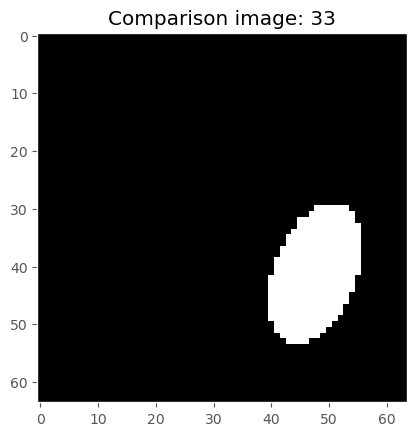

In [116]:
plt.title("Comparison image: {}".format(dataset.class_names[valid_data[idx]['class_label']]))
plot_image('dataset/'+valid_data[idx]['img_path'])

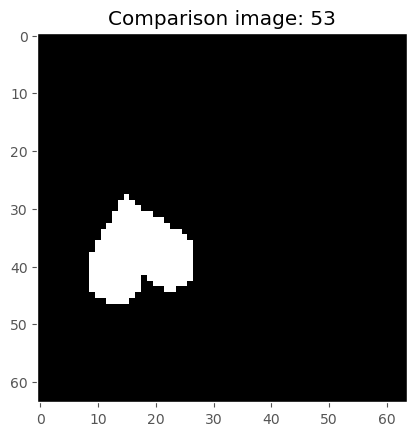

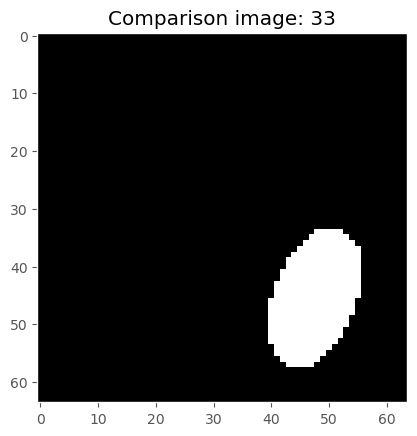

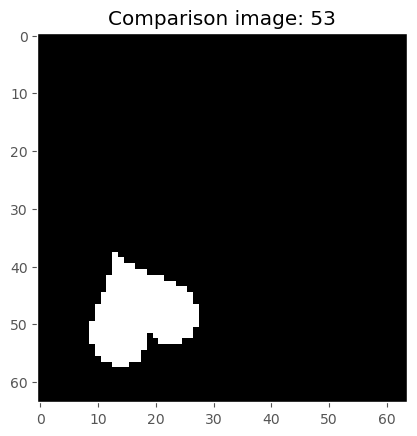

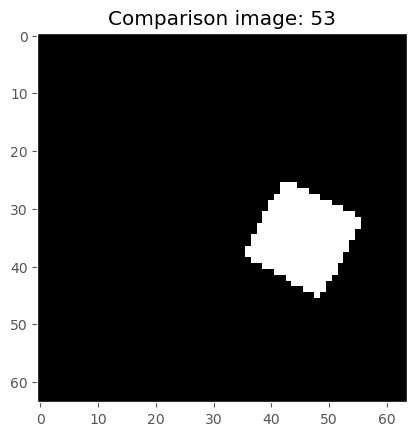

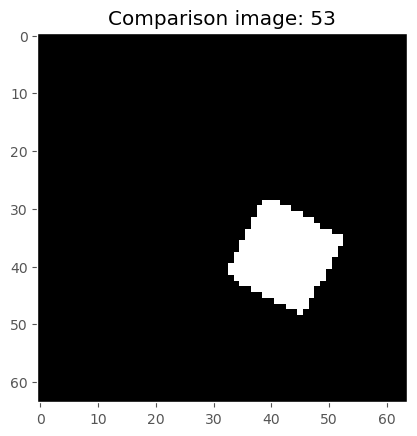

In [117]:
for i in their_images:
    plt.title("Comparison image: {}".format(dataset.class_names[train_data[i]['class_label']]))
    plot_image('dataset/'+train_data[i]['img_path'])

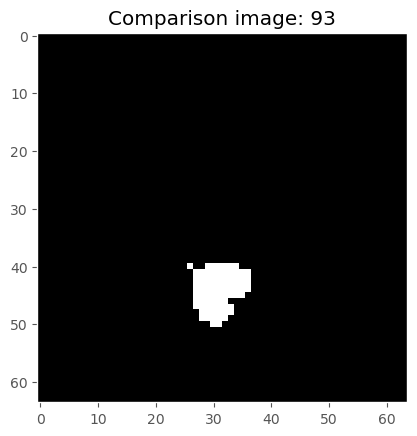

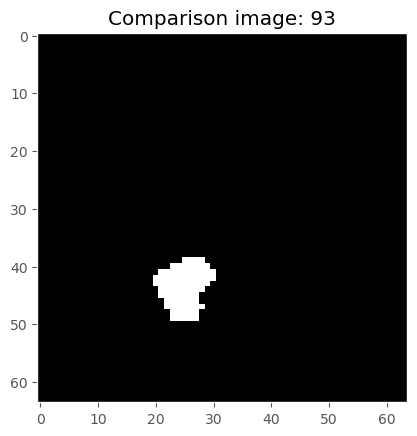

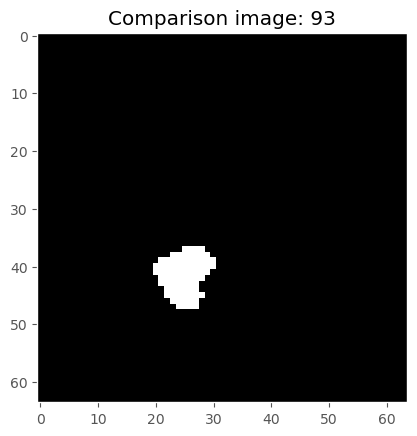

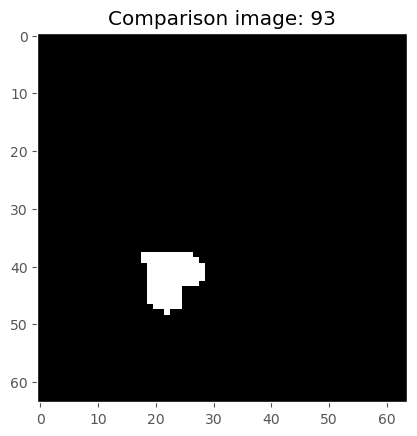

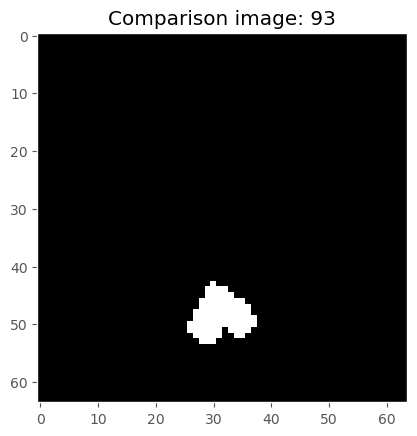

In [118]:
for i in our_images:
    plt.title("Comparison image: {}".format(dataset.class_names[train_data[i]['class_label']]))
    plot_image('dataset/'+train_data[i]['img_path'])

## Write our results

In [120]:
w = open("results/knn/{}.txt".format(dataset.experiment_name),"w")

w.write("logit_acc: {}\n".format((acc(np.round(train_logits), train_x), acc(np.round(valid_logits), valid_x), acc(np.round(test_logits), test_x))))
w.write("fix_acc: {}\n".format((acc(train_predict, train_x), acc(valid_predict, valid_x), acc(test_predict, test_x))))
w.write("logit_knn: {}\n".format(evaluate_knn(train_logits,train_y,test_logits,test_y)))
w.write("round_knn: {}\n".format(evaluate_knn(np.round(train_logits),train_y,np.round(test_logits),test_y)))
w.write("predict_knn: {}\n".format(evaluate_knn(train_predict,train_y,test_predict,test_y)))
w.write("prob_1: {}\n".format(evaluate_knn(train_predict_prob_1,train_y,test_predict_prob_1,test_y)))
w.write("prob_2: {}\n".format(evaluate_knn(train_predict_prob_2,train_y,test_predict_prob_2,test_y)))
w.write("concept_prob: {}\n".format(evaluate_knn(train_predict_concept_proba,train_y,test_predict_concept_proba,test_y)))
w.write("trimmed: {}\n".format(evaluate_knn(train_predict_trimmed,train_y,test_predict_trimmed,test_y)))
w.write("baseline: {}\n".format(", ".join([str(i) for i in eval_baseline])))
w.write("concept: {}\n".format(", ".join([str(i) for i in eval_ours])))
w.write("idx: {}\n".format(idx))
w.write("y_image: {}\n".format(valid_y[idx]))
w.write("baseline_image: {}\n".format(predictions_regular[idx]))
w.write("concept_image: {}\n".format(predictions_ours[idx]))
w.write("baseline_images: {}\n".format(their_images))
w.write("concept_images: {}\n".format(our_images))

w.close()

### Write the predict probabilities as the new training dataset; see how MLPs do

In [121]:
np.save(open("results/logits/{}/train_c_fixed.npy".format(dataset.experiment_name),"wb"),train_predict_concept_proba)

In [122]:
np.save(open("results/logits/{}/valid_c_fixed.npy".format(dataset.experiment_name),"wb"),valid_predict_concept_proba)

In [123]:
np.save(open("results/logits/{}/test_c_fixed.npy".format(dataset.experiment_name),"wb"),test_predict_concept_proba)